In [1]:
import os
os.chdir('../../')
os.getcwd()

'/mnt/c/Users/jam60/OneDrive/Repos/vivaldi/back_testing'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from v2.model import Trading
from v2.strategy.indicators.smma import SMMA
from v2.strategy.indicators.stochastic_oscillator import StochasticOscillator
from v2.strategy.indicators.bollinger_bands import BollingerBands
from v2.strategy.indicators.rsi import RSI
from v2.strategy.indicators.macd import MACD
from v2.strategy.indicators.param import Param

In [4]:
def load_config():
    my_config = {}
    with open('config.config') as config:
        for line in config:
            args = line.split('=')
            my_config[args[0]] = args[1].rstrip().split(',')
    return my_config

model = Trading(load_config())


In [5]:
datasets = model.dfs
appended_dataset = pd.DataFrame()
for d in datasets:
    training_set = d[0]
    training_set['trough'] = training_set.iloc[argrelextrema(training_set.close.values, np.less_equal, order=480)[0]]['close']
    training_set['peak'] = training_set.iloc[argrelextrema(training_set.close.values, np.greater_equal, order=480)[0]]['close']
    ema_fast = Param(5, 10000, 0, 'ema_fast', 60)
    ema_slow= Param(6, 10001, 0, 'ema_slow', 120)
    signal = Param(5, 10001, 0, 'signal', 90)
    macd_ = MACD(_params=[ema_fast, ema_slow, signal], _name='macd')
    macd_.genData(training_set, gen_new_values=False)
    boll_period = Param(5, 10000, 0, 'period', 90)
    boll_bands = BollingerBands(_params=[boll_period], _name='bollinger_bands')
    boll_bands.genData(training_set, gen_new_values=False)
    stoch_highlow = Param(5, 10000, 0, 'highlow_range', 90.0)
    stoch_k = Param(5, 10000, 0, 'k_period', 270.0)
    stoch_oscillator = StochasticOscillator(_params=[stoch_highlow, stoch_k], _name='stochastic_oscillator')
    stoch_oscillator.genData(training_set, gen_new_values=False)
    rsi_period = Param(5, 10000, 0, 'period', 90.0)
    rsi_ = RSI(_params=[rsi_period], _name='rsi')
    rsi_.genData(training_set, gen_new_values=False)
    smma_period = Param(5, 10000, 0, 'period', 90.0)
    smma_ = SMMA(_params=[smma_period], _name='smma')
    smma_.genData(training_set, gen_new_values=False)
    training_set[['trough', 'peak']] = training_set[['trough', 'peak']].fillna(0)
    training_set['slope'] = (training_set['close'].rolling(window=30).max() - training_set['close'].rolling(window=30).min()) / training_set['close'].rolling(window=30).max()
    training_set = training_set.dropna()
    appended_dataset = appended_dataset.append(training_set)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from sklearn.model_selection import train_test_split

trough_input_data = appended_dataset[['stosc_k', 'slope', 'macd_diff', 'rsi']]
appended_dataset['trough'] = appended_dataset['trough'].gt(0).astype(int)
is_trough = appended_dataset[['trough']]

x_train, x_test, y_train, y_test = train_test_split(trough_input_data.values, is_trough.values, test_size=0.2, shuffle=False)


x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

x_train.shape









(2599671, 1, 4)

In [50]:
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-5)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
num_ones = int(sum(y_train))
zero_weight = num_ones / len(y_train)
one_weight = (len(y_train) - num_ones) / len(y_train)
model_weights = []
for x in y_train:
    if x == 0.0:
        model_weights.append(zero_weight)
    else:
        model_weights.append(one_weight)
model_weights = np.array(model_weights)




In [51]:
model_weights

array([0.00219489, 0.00219489, 0.00219489, ..., 0.00219489, 0.00219489,
       0.00219489])

In [52]:
model.fit(x_train, y_train, epochs=3, sample_weight=model_weights, validation_data=(x_test, y_test))

Epoch 1/3
81240/81240 [==============================] - 372s 5ms/step - loss: 0.0023 - accuracy: 0.8213 - val_loss: 0.3194 - val_accuracy: 0.8490
Epoch 2/3
81240/81240 [==============================] - 380s 5ms/step - loss: 0.0016 - accuracy: 0.8308 - val_loss: 0.1448 - val_accuracy: 0.9097
Epoch 3/3
81240/81240 [==============================] - 359s 4ms/step - loss: 0.0018 - accuracy: 0.8324 - val_loss: 0.2443 - val_accuracy: 0.8979


In [71]:
trading = Trading(load_config())
datasets = trading.dfs
test_data = datasets[0][0]

macd_.genData(test_data, gen_new_values=False)

boll_bands.genData(test_data, gen_new_values=False)

stoch_oscillator.genData(test_data, gen_new_values=False)

rsi_.genData(test_data, gen_new_values=False)
test_data['slope'] = (test_data['close'].rolling(window=10).max() - test_data['close'].rolling(window=10).min()) / test_data['close'].rolling(window=10).max()
test_data = test_data.dropna()

new_input_data_trough = test_data[['stosc_k', 'slope', 'macd_diff', 'rsi']].values
new_input_data_trough = np.reshape(new_input_data_trough, (new_input_data_trough.shape[0], 1, new_input_data_trough.shape[1]))
predictions = model.predict(new_input_data_trough)[:,1]


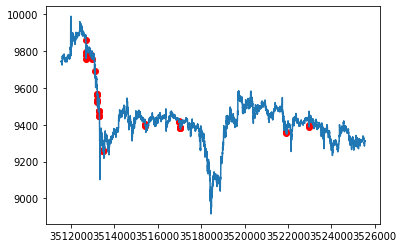

In [73]:

test_data['predictions_trough'] = predictions
def insert_predictions(close, prediction):
    if prediction > 0.95:
        return close
    else:
        return None
test_data['predictions_trough'] = test_data.apply(lambda row: insert_predictions(row['close'], row['predictions_trough']), axis=1)
plt.scatter(test_data.index, test_data['predictions_trough'], c='r')
# axes = plt.gca()
# axes.set_ylim([79,81])
plt.plot(test_data.index, test_data['close'])
plt.show()

In [15]:
model.save('/mnt/c/Users/jam60/OneDrive/Repos/vivalid/back_testing/troughs_lstm.sav')

INFO:tensorflow:Assets written to: /mnt/c/Users/jam60/OneDrive/Repos/vivalid/back_testing/troughs_lstm.sav/assets
